First build rectangular distribution.

In [2]:
# import the module build in a different folder
from scattering_structure.scattering_structure import ScatteringStructure
import numpy as np
import importlib.util
import os

# Add the DLL directory
os.add_dll_directory("C:\\Program Files\\Lumerical\\v232\\api\\python")

# Define the module name and file path
module_name = "lumapi"
#file_path = "C:\\Program Files\\Lumerical\\v232\\api\\python\\lumapi.py"
file_path = "C:\\Program Files\\Lumerical\\v232\\api\\python\\lumapi.py"

def load_module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# Load the module
lumapi = load_module_from_file(module_name, file_path)

C:\Program Files\Lumerical\v232\api\python\lumapi.py:895: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


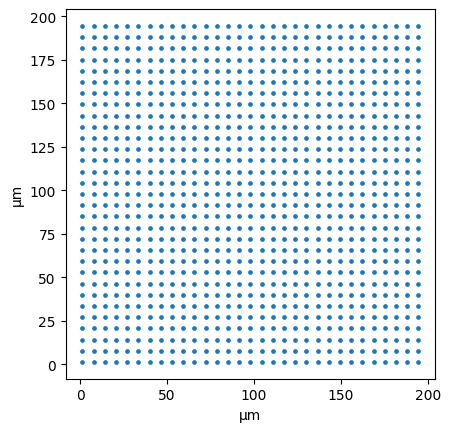

Density =  0.1361335890145112 /um^2


In [2]:
rect = ScatteringStructure(geometry={'type': 'box', 'lx': 200, 'ly': 200},
                           arrangement={'type':'rectangular', 'dist': 6.44},
                           scatterer_radius=1.343
                           )
rect.plot_distribution()
rect_rms = rect.rms()
rect_density = rect.density()

# print for further use
print('Density = ', rect_density, '/um^2')

Then build a poisson disc distribution on top of that. Which mimiks the same density
#### Note:
The geometry is now given as circle i.e., the distribution will automatically be reduced to a circle inside the class.

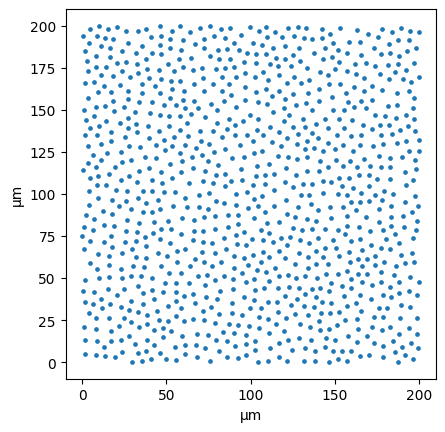

Mean of RMS(dist) =  0.1345753481412962 /um^2


In [3]:
pois = ScatteringStructure(geometry={'type': 'circle', 'lx': 200, 'ly': 200,
                                     'circle_radius': 90},
                           arrangement={'type':'poisson_disc', 'optimization': True,
                                        'measure_of_merit':'density',
                                        'target_mom': rect_density,
                                        'optimization_outer_n': 4,
                                        'optimization_inner_n': 8},
                           scatterer_radius=1.343
                           )
pois.plot_distribution()
pois_density = pois.density()

# print for further use
print('Mean of RMS(dist) = ', pois_density, '/um^2')

Now plot the distribution after it's been reduced to the desired geometry.
#### Note:
The points have also been shifted to lie around the origin. Making later exporting to Lumerical or gds easier.

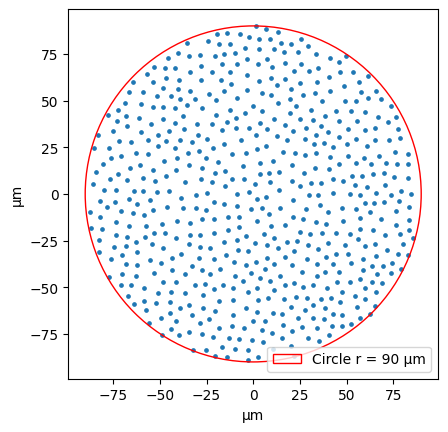

In [4]:
pois.plot_device()

Save the distribution to a file

In [5]:
pois.save_device(filepath='first_device.txt')

Distribution saved to first_device.txt


### Load first device and it's distribution

In [2]:
load_pois =  ScatteringStructure(geometry={'type': 'load_from_file'},
                                 arrangement={'type': 'load_from_file', 
                                              'filepath': 'first_device.txt'},
                                 scatterer_radius=1.343
                           )

Distribution loaded from first_device.txt


Let's try plotting the distribution again

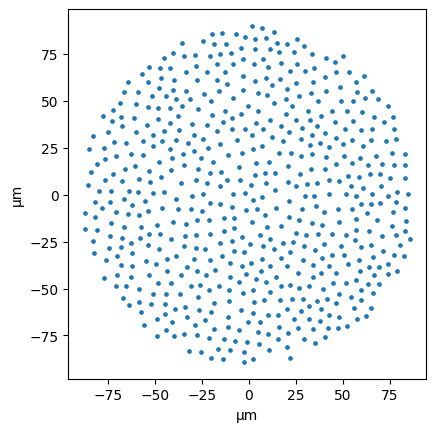

In [3]:
load_pois.plot_distribution()

## Create structure inside lumerical

In [8]:
## Constants
wavelength = 1.55 # central wavelength 
block_length = 210
block_width = 210
modes = 100


WG = {
    "length": block_length,
    "width": block_width,
    "height": 0.22,
    "matname": "Si3N4 (Silicon Nitride) - Luke"
}

BOX = {
    "length": block_length,
    "width": block_width,
    "height": 3,
    "matname": "SiO2 (Glass) - Palik"
}

SUB = {
    "length": block_length,
    "width": block_width,
    "height": 1,
    "matname": "Si (Silicon) - Palik"
}

AIR = {
    "length": block_length,
    "width": block_width,
    "height": 5,
    "matname": "etch"
}

RING = {
    "inner radius": 0.9384,
    "outer radius": 1.3432,
    "height": 0.070,
    "matname": "etch"
}


#### SiO2, Si3N4, Air stack

In [6]:
fdtd = lumapi.FDTD()
# Si
fdtd.addrect()
fdtd.set('name', 'SUB')
coordinates = {"x": 0,
                   "x span": SUB["length"] * 1e-6,
                   "y": 0,
                   "y span": SUB["width"] * 1e-6,
                   "z min": 0,
                   "z max": SUB["height"] * 1e-6}
fdtd.set(coordinates)
fdtd.select('SUB')
fdtd.set('material', SUB["matname"])
# default settings
fdtd.set('color opacity', 0.5)
fdtd.set('override mesh order from material database', 1)
fdtd.set('mesh order', 3)
# SiO2
fdtd.addrect()
fdtd.set('name', 'BOX')
coordinates = {"x": 0,
                   "x span": BOX["length"] * 1e-6,
                   "y": 0,
                   "y span": BOX["width"] * 1e-6,
                   "z min": SUB["height"] * 1e-6,
                   "z max": (SUB["height"] + BOX["height"]) * 1e-6}
fdtd.set(coordinates)
fdtd.select('BOX')
fdtd.set('material', BOX["matname"])
# default settings
fdtd.set('color opacity', 0.5)
fdtd.set('override mesh order from material database', 1)
fdtd.set('mesh order', 3)
# Si3N4
fdtd.addrect()
fdtd.set('name', 'WG')
coordinates = {"x": 0,
                   "x span": WG["length"] * 1e-6,
                   "y": 0,
                   "y span": WG["width"] * 1e-6,
                   "z min": (SUB["height"] + BOX["height"]) * 1e-6,
                   "z max": (SUB["height"] + BOX["height"] + WG["height"]) * 1e-6}
fdtd.set(coordinates)
fdtd.select('WG')
fdtd.set('material', WG["matname"])
# default settings
fdtd.set('color opacity', 0.5)
fdtd.set('override mesh order from material database', 1)
fdtd.set('mesh order', 3)
# Air
fdtd.addrect()
fdtd.set('name', 'AIR')
coordinates = {"x": 0,
                   "x span": AIR["length"] * 1e-6,
                   "y": 0,
                   "y span": AIR["width"] * 1e-6,
                   "z min": (SUB["height"] + BOX["height"] + WG["height"]) * 1e-6,
                   "z max": (SUB["height"] + BOX["height"] + WG["height"] + AIR["height"]) * 1e-6}
fdtd.set(coordinates)
fdtd.select('AIR')
fdtd.set('material', AIR["matname"])
# default settings
fdtd.set('color opacity', 0.5)
fdtd.set('override mesh order from material database', 1)
fdtd.set('mesh order', 3)

#### Create etch wholes

In [8]:
i = 0
for (x, y) in load_pois.get_reduced_points():
    name = str(i)
    fdtd.addring()
    fdtd.set('name', name)
    coordinates = {"x": x*1e-6,
                   "y": y*1e-6,
                   "z": (SUB["height"] + BOX["height"] + WG["height"] - 0.5*RING["height"]) * 1e-6,
                   "z span": RING["height"] * 1e-6,
                   "inner radius": RING["inner radius"] * 1e-6,
                   "outer radius": RING["outer radius"] * 1e-6}
    fdtd.set(coordinates)
    fdtd.select(name)
    fdtd.set('material', RING["matname"]) 
    # fdtd.set('addtogroup', 'RINGS')
    # default settings
    fdtd.set('color opacity', 0.5)
    fdtd.set('override mesh order from material database', 1)
    fdtd.set('mesh order', 1)
    fdtd.addtogroup("RINGS")
    i += 1 
    
# save file as is
fdtd.save("first_device.fsp")

#### Add solver

In [10]:
fdtd = lumapi.FDTD(filename="first_device.fsp")

In [7]:
configuration = {
    "FDTD": {
        "simulation time": 200e-15,  # in seconds
        "dimension": "3D",
        "x": 0,
        "y": 0.0,
        "z min": 0.0,
        "x span": block_length * 1e-6,
        "y span": block_width * 1e-6,
        "z max": (SUB["height"] + BOX["height"] + WG["height"] + AIR["height"]) * 1e-6,
        "mesh accuracy": 1,
        "min mesh step": 0.025*1e-6
    }
}

# add solver
fdtd.addfdtd()
for key, value in configuration["FDTD"].items():
    fdtd.setnamed("FDTD",key, value)

# add boundary conditions
# is PMC by default

fdtd.save("first_device.fsp")

#### Add sources

#### Add Monitor

In [19]:
# 2D y-normal monitor
y_normal_configuration = {
    "monitor type": 6, # 2D y normal
    "y": 0.0,
    "z min": 0.0,
    "x span": block_length * 1e-6,
    "z max": (SUB["height"] + BOX["height"] + WG["height"] + AIR["height"]) * 1e-6,
}
fdtd.addpower()
fdtd.set("name", "2D Y-normal")
# set geometry
for key, value in y_normal_configuration.items():
    fdtd.set(key, value)
    
############################################
# slab-edge monitor(s)
# four individual monitors have to be added. 
###########################################
slab_edge_configuration = {
    "monitor type": 6, # 2D y normal
    "y": -0.5*block_width * 1e-6,
    "x": 0,
    "x span": block_length * 1e-6,
    "z min": (SUB["height"] + BOX["height"]) * 1e-6,
    "z max": (SUB["height"] + BOX["height"] + WG["height"]) * 1e-6,
}
fdtd.addpower()
fdtd.set("name", "1")
# set geometry
for key, value in slab_edge_configuration.items():
    fdtd.set(key, value)
fdtd.addtogroup("WG edge monitor(s)")
#########################
slab_edge_configuration = {
    "monitor type": 6, # 2D y normal
    "y": +0.5*block_width * 1e-6,
    "x": 0,
    "x span": block_length * 1e-6,
    "z min": (SUB["height"] + BOX["height"]) * 1e-6,
    "z max": (SUB["height"] + BOX["height"] + WG["height"]) * 1e-6,
}
fdtd.addpower()
fdtd.set("name", "2")
# set geometry
for key, value in slab_edge_configuration.items():
    fdtd.set(key, value)
fdtd.addtogroup("WG edge monitor(s)")
#########################
slab_edge_configuration = {
    "monitor type": 5, # 2D y normal
    "x": -0.5*block_length * 1e-6,
    "y": 0,
    "y span": block_width * 1e-6,
    "z min": (SUB["height"] + BOX["height"]) * 1e-6,
    "z max": (SUB["height"] + BOX["height"] + WG["height"]) * 1e-6,
}
fdtd.addpower()
fdtd.set("name", "3")
# set geometry
for key, value in slab_edge_configuration.items():
    fdtd.set(key, value)
fdtd.addtogroup("WG edge monitor(s)")
#########################
slab_edge_configuration = {
    "monitor type": 5, # 2D y normal
    "x": +0.5*block_length * 1e-6,
    "y": 0,
    "y span": block_width * 1e-6,
    "z min": (SUB["height"] + BOX["height"]) * 1e-6,
    "z max": (SUB["height"] + BOX["height"] + WG["height"]) * 1e-6,
}
fdtd.addpower()
fdtd.set("name", "4")
# set geometry
for key, value in slab_edge_configuration.items():
    fdtd.set(key, value)
fdtd.addtogroup("WG edge monitor(s)")

fdtd.save("first_device.fsp")